In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [6]:
# read trajectory data
data_path = "/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data"
atoms_selection = "name CA"
print("selected atoms:", atoms_selection)

# load data
prmtopFileName =  data_path + "/s1_init_protein_only.gro"
trajFiles = [data_path+"/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr"]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_atoms = coord.select_atoms(atoms_selection)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_atoms.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_atoms.n_atoms,3),dtype=float)
count = 0

# no need to multiply by 10
for ts in coord.trajectory:
    trajData[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

selected atoms: name CA
['/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/run_with_1us_data/opes_ld1_bf_12.0_barrier_15.0_wrapped_protein_only.trr']
1
Number of atoms in trajectory: 5835
Number of frames in trajectory: 21001
Number of atoms being analyzed: 375
Number of frames being analyzed: 21001


In [22]:
## load data from COLVAR
time, ld1, cleft_dist, dihedral, opes_bias = np.loadtxt(data_path+"/COLVAR_EDITED", usecols=(0,1,2,3,4), unpack=True)

time *= 1e-3 # in ns

In [23]:
print(time.shape)
print(opes_bias.shape)

(1050001,)
(1050001,)


In [24]:
ld1_grids = np.linspace(-41.0, 41.0, 100, endpoint=True)
dihedral_grids = np.linspace(-np.pi, np.pi, 100, endpoint=True)
print(ld1_grids.shape)

# load the final FE from final STATE file  (time=1050ns)
fe_state_final = np.loadtxt(data_path+"/2d_fe_actin_ld1+dihedral.dat", usecols=2).reshape([100,100])/4.184
print(fe_state_final.shape)

(100,)
(100, 100)


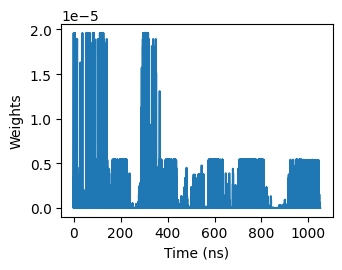

In [25]:
# find the indices
x_indx = np.digitize(ld1, ld1_grids, right=True)
y_indx = np.digitize(dihedral, dihedral_grids, right=True)

kbt=0.616033 # in kcal/mol unit

weights = np.empty(time.shape[0])
for i in range(time.shape[0]):
    weights[i] = np.exp(-fe_state_final.T[x_indx[i], y_indx[i]]/kbt)
    
weights /= np.sum(weights)

plt.figure(figsize=(3.5,2.5))
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights)

In [8]:
## define cluster array 
cluster_array = np.arange(1,7,1).astype(int)
print("#clusters :", cluster_array)

#clusters : [1 2 3 4 5 6]


In [7]:
print(trajData.shape)
print(weights[::50].shape)

(21001, 375, 3)


NameError: name 'weights' is not defined

# Run cluster scan with weights from OPES_METAD simulation

In [28]:
train, cv = scripts.cross_validate_cluster_scan\
(trajData, 20791, frame_weights = weights[::50], covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

Number of frames to train each model: 20791
Number of frames to predict each model: 210
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1             968.924          43.481
              1               2               1            1031.989          41.388
              1               2               2            1006.407          65.895
              1               2               3            1023.710          56.260
              1               2               4            1031.865          43.417
              1               2               5            1022.684          57.038
              1               2               6            1034.077          45.654
              1               2               7            1011.681

              2               6               3            1110.615         107.557
              2               6               4            1111.102          91.693
              2               6               5            1111.058         102.333
              2               6               6            1106.882          94.794
              2               6               7            1106.983          93.033
              2               6               8            1141.214         105.461
              2               6               9            1076.923         126.632
              2               6              10            1116.151         105.689
              3               1               1             968.800          42.226
              3               2               1             998.216          58.037
              3               2               2            1002.695          50.196
              3               2               3            1004.420         

              4               5               9            1095.448          96.175
              4               5              10            1126.493          85.417
              4               6               1            1114.786          99.254
              4               6               2            1107.088         117.369
              4               6               3            1109.348         111.921
              4               6               4            1113.548          83.416
              4               6               5            1134.754         102.364
              4               6               6            1084.229         116.664
              4               6               7            1098.965         101.480
              4               6               8            1099.796         114.870
              4               6               9            1127.033         107.192
              4               6              10            1128.100         

In [9]:
train = np.loadtxt("train_fbias.dat")[:,1:]
cv = np.loadtxt("cv_fbias.dat")[:,1:]

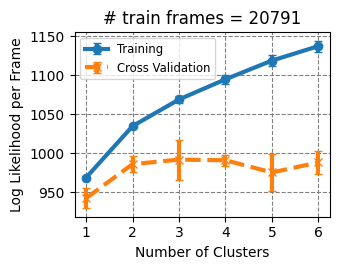

In [10]:
# create figure
plt.figure(figsize=(3.5,2.8), dpi= 100, facecolor='w', edgecolor='k')

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

plt.errorbar(cluster_array,train_mean, train_std, fmt='-o', lw=3, capsize=3, label="Training")

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

plt.errorbar(cluster_array, cv_mean, cv_std, fmt='--x', lw=3, capsize=3, label="Cross Validation")

plt.grid(which='major', axis='both', color='#808080', linestyle='--')

plt.ylabel("Log Likelihood per Frame")
plt.title("# train frames = 20791")
plt.xlabel("Number of Clusters")
plt.tick_params(axis='both')
plt.legend(fontsize="small")
plt.tight_layout()